In [3]:
!pip install qiskit.ignis

  Using cached qiskit_ignis-0.7.1-py3-none-any.whl (198 kB)

[notice] A new release of pip available: 23.1.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [4]:
#Import general libraries (needed for functions)
import numpy as np
from numpy import random
import qiskit

#Import Qiskit classes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error

#Import the accreditation functions.
from qiskit.ignis.verification.accreditation import AccreditationFitter,AccreditationCircuits


/tmp/ipykernel_81/823391348.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.accreditation import AccreditationFitter,AccreditationCircuits


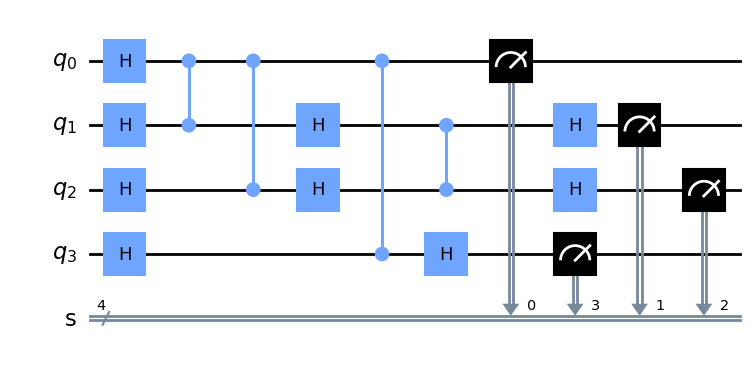

In [5]:
# Create a Quantum Register with n_qb qubits.
q_reg = QuantumRegister(4, 'q')
# Create a Classical Register with n_qb bits.
c_reg = ClassicalRegister(4, 's')
# Create a Quantum Circuit acting on the q register
target_circuit = QuantumCircuit(q_reg, c_reg)

target_circuit.h(0)
target_circuit.h(1)
target_circuit.h(2)
target_circuit.h(3)
target_circuit.cz(0,1)
target_circuit.cz(0,2)
target_circuit.h(1)
target_circuit.h(2)
target_circuit.cz(0,3)
target_circuit.cz(1,2)
target_circuit.h(1)
target_circuit.h(2)
target_circuit.h(3)

target_circuit.measure(q_reg, c_reg)

target_circuit.draw(output = 'mpl')

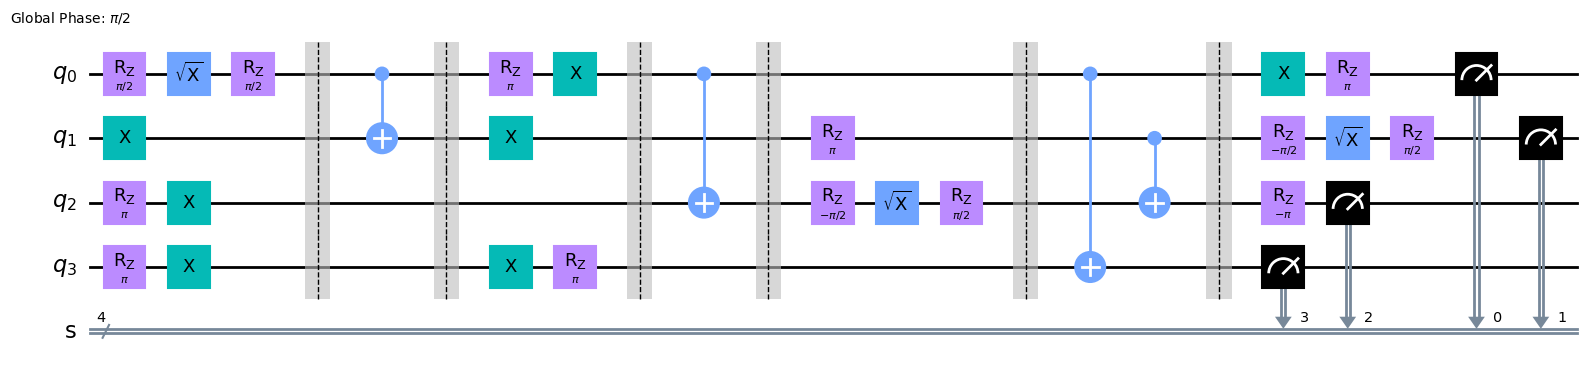

In [6]:
accsys = AccreditationCircuits(target_circuit)

v = 10

circ_list, postp_list, v_zero = accsys.generate_circuits(v)
circ_list[(v_zero)%(v+1)].draw(output = 'mpl')

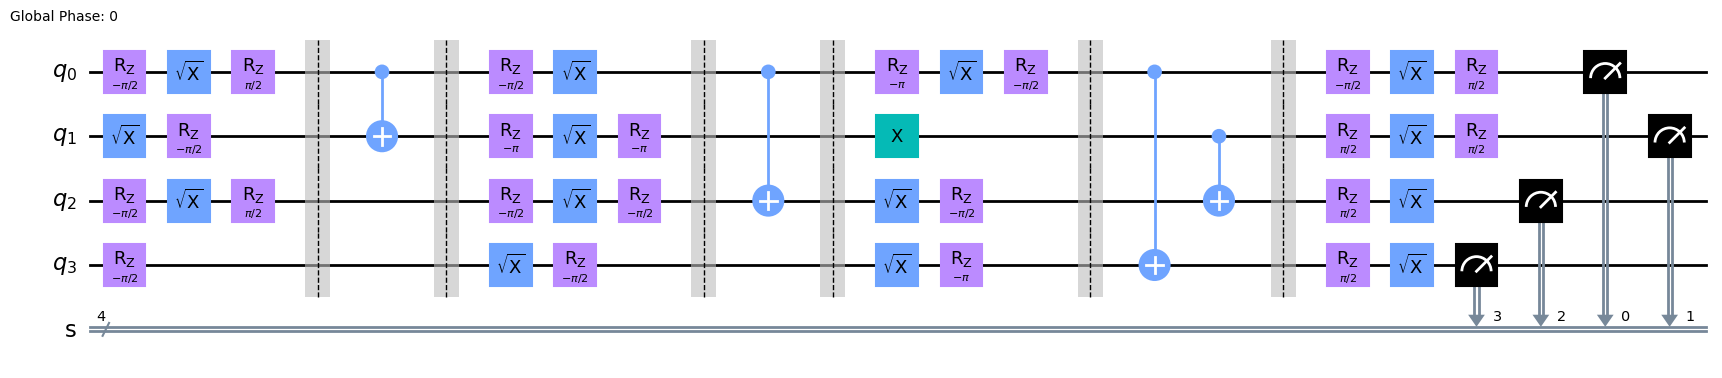

In [7]:
circ_list[(v_zero+1)%(v+1)].draw(output = 'mpl')


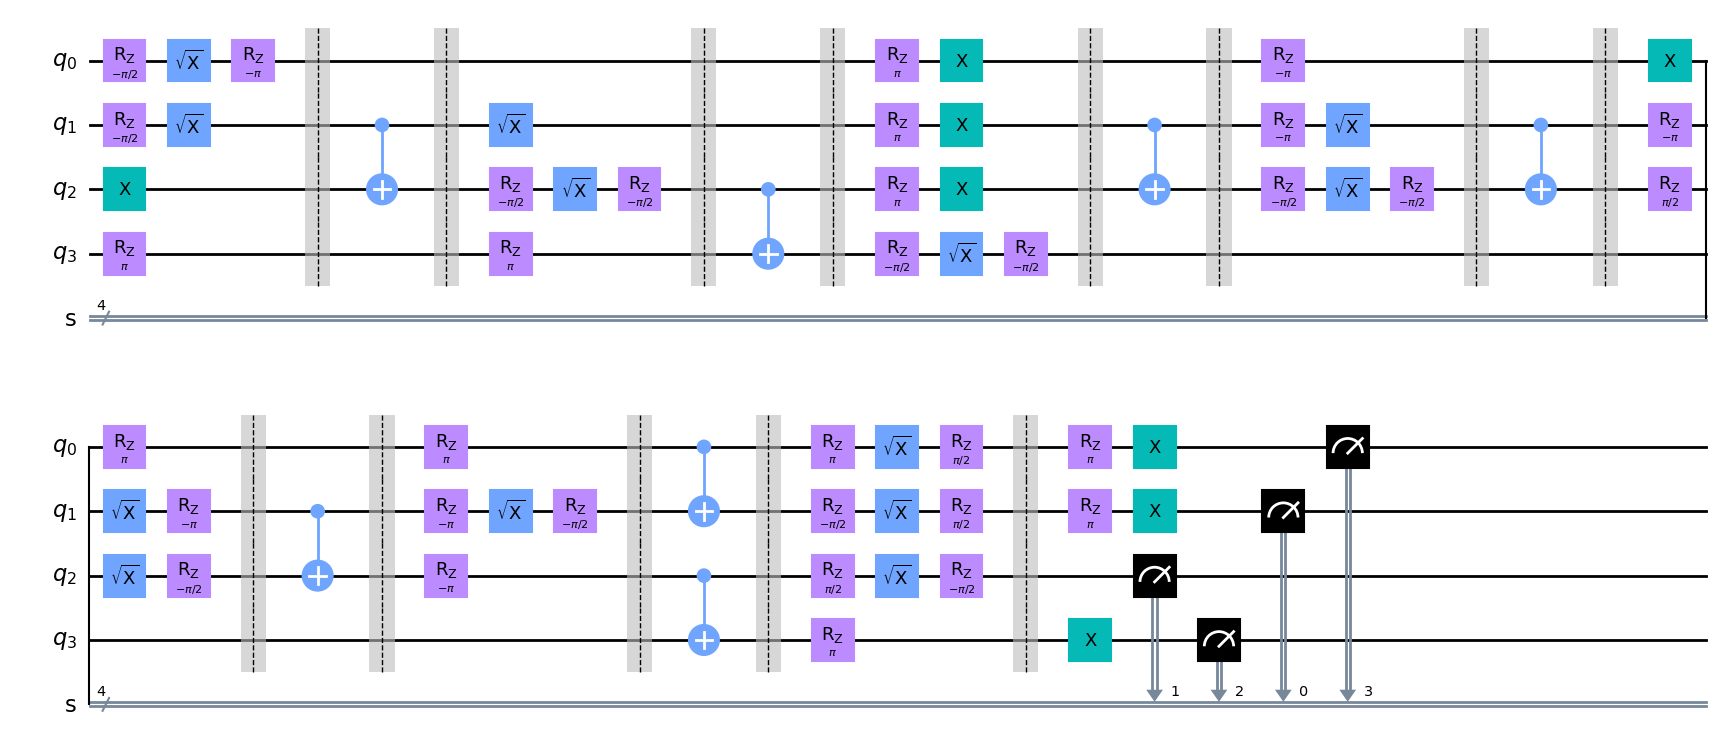

In [8]:
accsys.target_circuit(target_circuit, two_qubit_gate='cx', coupling_map=[[0,1],[1,2],[2,3]] )

v = 10

circ_list, postp_list, v_zero = accsys.generate_circuits(v)
circ_list[(v_zero)%(v+1)].draw(output = 'mpl')

In [9]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

test_1 = AccreditationFitter()

# Create target and trap circuits with random Pauli gates
accsys = AccreditationCircuits(target_circuit)
circuit_list, postp_list, v_zero = accsys.generate_circuits(v)


job = execute(circuit_list,
              simulator,
              shots=1)
result = job.result()
# Post-process the outputs and see if the protocol accepts
test_1.single_protocol_run(result, postp_list, v_zero)

print("Outputs of the target: ",test_1.outputs," , AP",test_1.flag,"these outputs!")

Outputs of the target:  {'1101': 1}  , AP accepted these outputs!


/tmp/ipykernel_81/2203906122.py:15: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_1.single_protocol_run(result, postp_list, v_zero)


In [10]:
d = 20

test_2 = AccreditationFitter()

for run in range(d):

    # Create target and trap circuits with random Pauli gates
    circuit_list, postp_list, v_zero = accsys.generate_circuits(v)


    # Implement all these circuits

    job = execute(circuit_list,
                  simulator,
                  shots=1)
    result = job.result()

    # Post-process the outputs and see if the protocol accepts
    test_2.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_2.flag)

print('\nAfter',test_2.num_runs,'runs, AP has accepted',test_2.N_acc,'outputs!')

print('\nList of accepted outputs:\n', test_2.outputs)

/tmp/ipykernel_81/4200020469.py:19: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_2.single_protocol_run(result, postp_list, v_zero)


Protocol run number 1 , outputs of the target accepted
Protocol run number 2 , outputs of the target accepted
Protocol run number 3 , outputs of the target accepted
Protocol run number 4 , outputs of the target accepted
Protocol run number 5 , outputs of the target accepted
Protocol run number 6 , outputs of the target accepted
Protocol run number 7 , outputs of the target accepted
Protocol run number 8 , outputs of the target accepted
Protocol run number 9 , outputs of the target accepted
Protocol run number 10 , outputs of the target accepted
Protocol run number 11 , outputs of the target accepted
Protocol run number 12 , outputs of the target accepted
Protocol run number 13 , outputs of the target accepted
Protocol run number 14 , outputs of the target accepted
Protocol run number 15 , outputs of the target accepted
Protocol run number 16 , outputs of the target accepted
Protocol run number 17 , outputs of the target accepted
Protocol run number 18 , outputs of the target accepted
P

In [13]:
theta = 5/100

test_2.bound_variation_distance(theta)

print("AP accepted",test_2.N_acc,"out of",test_2.num_runs,"times.")
print("With confidence",test_2.confidence,"AP certifies that VD is upper-bounded by",test_2.bound)

AP accepted 20 out of 20 times.
With confidence 1.0 AP certifies that VD is upper-bounded by 0.16267942583732053


/tmp/ipykernel_81/177761758.py:3: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_2.bound_variation_distance(theta)


In [14]:
noise_model = NoiseModel()

p1q = 0.003
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u1')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u3')
p2q = 0.03
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2q, 2), 'cx')

basis_gates = ['u1','u2','u3','cx']

In [17]:
test_3 = AccreditationFitter()

for run in range(d):

    # Create target and trap circuits with random Pauli gates
    circuit_list, postp_list, v_zero = accsys.generate_circuits(v)
    job = execute(circuit_list,
                  simulator,
                  noise_model=noise_model,
                  basis_gates=basis_gates,
                  shots=1,
                  )
    result = job.result()
    # Post-process the outputs and see if the protocol accepts
    test_3.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_3.flag)

print("\nAP accepted",test_3.N_acc,"out of",test_3.num_runs,"times.")
print('\nList of accepted outputs:\n', test_3.outputs)

theta = 5/100

test_3.bound_variation_distance(theta)
print("\nWith confidence",test_3.confidence,"AP certifies that VD is upper-bounded by",test_3.bound)

/tmp/ipykernel_81/2941147633.py:15: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_3.single_protocol_run(result, postp_list, v_zero)


Protocol run number 1 , outputs of the target rejected
Protocol run number 2 , outputs of the target rejected
Protocol run number 3 , outputs of the target accepted
Protocol run number 4 , outputs of the target rejected
Protocol run number 5 , outputs of the target rejected
Protocol run number 6 , outputs of the target rejected
Protocol run number 7 , outputs of the target accepted
Protocol run number 8 , outputs of the target rejected
Protocol run number 9 , outputs of the target accepted
Protocol run number 10 , outputs of the target rejected
Protocol run number 11 , outputs of the target rejected
Protocol run number 12 , outputs of the target rejected
Protocol run number 13 , outputs of the target accepted
Protocol run number 14 , outputs of the target rejected
Protocol run number 15 , outputs of the target rejected
Protocol run number 16 , outputs of the target rejected
Protocol run number 17 , outputs of the target rejected
Protocol run number 18 , outputs of the target rejected
P

/tmp/ipykernel_81/2941147633.py:23: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_3.bound_variation_distance(theta)


In [19]:
min_traps = 4
max_traps = 10


for num_trap_circs in range(min_traps,max_traps):

    test_4 = AccreditationFitter()
    for run in range(d):

        # Create target and trap circuits with random Pauli gates
        circuit_list, postp_list, v_zero = accsys.generate_circuits(num_trap_circs)

        job = execute(circuit_list,
                      simulator,
                      noise_model=noise_model,
                      basis_gates=basis_gates,
                      shots=1,
                      )
        result = job.result()

        # Post-process the outputs and see if the protocol accepts
        test_4.single_protocol_run(result, postp_list, v_zero)

    print("\nWith", num_trap_circs,
          "traps, AP accepted", test_4.N_acc,
          "out of", test_4.num_runs, "times.")
    test_4.bound_variation_distance(theta)
    print("With confidence", test_4.confidence,
          "AP with", num_trap_circs,
          "traps certifies that VD is upper-bounded by", test_4.bound)

/tmp/ipykernel_81/1911547381.py:22: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_4.single_protocol_run(result, postp_list, v_zero)



With 4 traps, AP accepted 11 out of 20 times.
With confidence 1.0 AP with 4 traps certifies that VD is upper-bounded by 0.6799999999999999


/tmp/ipykernel_81/1911547381.py:27: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_4.bound_variation_distance(theta)



With 5 traps, AP accepted 10 out of 20 times.
With confidence 1.0 AP with 5 traps certifies that VD is upper-bounded by 0.6296296296296298

With 6 traps, AP accepted 12 out of 20 times.
With confidence 1.0 AP with 6 traps certifies that VD is upper-bounded by 0.4415584415584415

With 7 traps, AP accepted 6 out of 20 times.
With confidence 1.0 AP with 7 traps certifies that VD is upper-bounded by 0.8500000000000001

With 8 traps, AP accepted 11 out of 20 times.
With confidence 1.0 AP with 8 traps certifies that VD is upper-bounded by 0.37777777777777777

With 9 traps, AP accepted 8 out of 20 times.
With confidence 1.0 AP with 9 traps certifies that VD is upper-bounded by 0.48571428571428554
